## Load Libraries and import modules 

In [1]:
# Load all the vanila libraries 
import numpy as np
import pandas as pd
import numpy.random as nrd
import os
import pathlib 
import sys
from typing import Callable


#
import umap

# Pytorch modules 
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

# this for the custom Dataset 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D



# Import tqdm for progress bar
from tqdm.auto import tqdm

# for timing functions
from timeit import default_timer as timer 

### Configure Project Parameters

In [2]:
# check your current directory
os.getcwd()

'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space'

**Important:** Run the configuration file first `configs.py`. Importing this script and setting the seed and device parameters before importing any of the other modules ensures that evereything is sync.

**Important** If you want *change the configuration parameters*, change them before importing and running the pipeline. 

In [3]:
from models_util import configs

Importing models_util.configs module
First set device and seed for reproducibility.
-----------------------------------------------


In [4]:
configs.get_configs()

'Seed: None, Device: None'

In [5]:
# print the global variables
print(configs.project_seed, configs.project_device)

None None


In [6]:
configs.set_seed(789)
device = configs.set_device(force_cpu=True)

# global variables have changed too
print(configs.project_seed, configs.project_device)

During configuration random seed 789 has been set.
789 cpu


In [7]:
# lets see if the get function also agrees:
configs.get_configs()

'Seed: 789, Device: cpu'

Now that all the configurations values are assigned globally, we can import the modules. If this is working, we expect each module to access the **same** **seed** and **device** we set. We are also expecting generated numbers **inside the modules** to be reproducible.

In [8]:
# Load home modules and check the device where they are running 
from models_util import utility_functions as uf

During configuration random seed 789 has been set.
Importing models_util.utility_functions, running in cpu with seed: 789


In [9]:
from models_util import custom_dataset as cd

During configuration random seed 789 has been set.
Importing models_util.custom_dataset, running in cpu with seed: 789


In [10]:
from models_util import cost_functions as cf

During configuration random seed 789 has been set.
Importing models_util.cost_functions, running in cpu with seed: 789


In [11]:
from models_util import VAE1 as v1 


During configuration random seed 789 has been set.
Importing models_util.VAE1, running in cpu with seed: 789


## SCBC Data scale and split for VAE
- We will perform min-max scaling to the TMT-Ratios of the proteomic SCBC data. <br>
- We will scale the array version of our scbc data, the `npscbc` matrix.
- Then we will copy this scaled matrix and reshuffle the copy. The `npscbc_scaled_shuffled` will be used for the model training and performance evaluattion. <br>
- The `npscbc_scaled` matrix with the original order of rows will be used later for the validation of the latent variables. <br> 
- It is important to use the non-missing min and max values of dataset row-by-row <br>

In [12]:
# create path and read the scbc data
data_path = os.getcwd() + "\\data\\processed\\" 
scbc = pd.read_csv(data_path+"prot_abms_norm.txt",delimiter="\t")

In [13]:
# convert to numpy 
npscbc = scbc.to_numpy()
np.isnan(npscbc).sum()


np.int64(15306)

In [14]:
# Get extreme values (non-missing) frome ach row. 
scbc_min = np.nanmin(npscbc, axis=1, keepdims=True)  # minimum among non-NaN
scbc_max = np.nanmax(npscbc, axis=1,keepdims=True)  # maximum among non-NaN

# check that that shapes and values are as expected 
print(scbc_max.shape,scbc_min.shape,np.isnan(scbc_max).sum(), np.isnan(scbc_min).sum())

(11209, 1) (11209, 1) 0 0


In [15]:
# scale data 
npscbc_scaled = (npscbc - scbc_min) /(scbc_max - scbc_min + 1e-8)
npscbc_scaled.shape

# npscbc_scaled[0:2,]

(11209, 54)

In [17]:
# shuffle the rows but keep scaled original
npscbc_scaled_shuffled = npscbc_scaled.copy()
np.random.shuffle(npscbc_scaled_shuffled)
# npscbc_scaled[1,],scbc.iloc[1,:12]


### Split Data 

In [18]:
train_data, val_data, test_data = uf.create_data_partition(
    npscbc_scaled_shuffled, test_perc=0.15, val=True, val_perc=0.1
)
train_data.shape, val_data.shape, test_data.shape

((8406, 54), (1121, 54), (1682, 54))

You can test reproducibility by re-runing the function and checking the data in the first index of the matrix. We expect it to be the same. 

### Pass data to Custom Dataset and DataLoaders 
- check that your data is numpy matrix.
- check if data is scaled to (0,1).
- create three custom dataset instances.
- the custom dataset will save all the data to memory and create a mask where NaNs are located.
- the numpy arrays will be converted to tensors of appropriate dimensions and NaNs to zeroes.
- then we pass the custom dataset to the dataloader object.
- The DataLoader object contains for each row (training example) i) a tensor of 1 x 130 columns with 0-1 scaled values, ii) a 1x130 mask indicating NA positions and iii) index of the examples per batch (could be 64, 128,..., batch_size). 

In [19]:
train_dataset = cd.ProteinDataset(train_data)
val_dataset = cd.ProteinDataset(val_data)
test_dataset = cd.ProteinDataset(test_data)

Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified


In [20]:
# pass data to the dataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,drop_last=True)

In [32]:
# the train loader is not reproducible bcs it shuffles but it is not seeded yet. 
# here is one batch of training examples 
# torch.manual_seed(888)


next(iter(train_loader))

[tensor([[0.2391, 0.1722, 0.1519,  ..., 0.4952, 0.5124, 0.4771],
         [0.0353, 0.0033, 0.0000,  ..., 0.5410, 0.5976, 0.5736],
         [0.0764, 0.0489, 0.0000,  ..., 0.1683, 0.0580, 0.1417],
         ...,
         [0.9355, 0.9443, 0.8803,  ..., 0.4635, 0.4635, 0.4635],
         [0.8342, 1.0000, 0.5116,  ..., 0.1154, 0.1154, 0.0902],
         [0.8522, 0.9352, 0.8787,  ..., 0.9263, 1.0000, 0.8641]]),
 tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([6772,  307, 1713, 5072, 4315,  982, 3389, 1842, 3162, 3762, 2830, 3983,
         2531, 2847, 7875, 3727, 2129, 5405, 1716,  652, 4243, 3225, 3548, 4350,
         4845, 5468, 5199, 4107, 1662, 8146,  296, 2400, 6955,

## Bit optimization Loop 
It comprises the run of the training and validation set. VAE inherently have a tendency to overfit, so it is important to keep the test set after training loop. In this tutorial we run one model. The name is based on a simple numbering system and its layers to track it down. Furthermore the train_val_loop creates a hyperparameter string to track other parameters. The whole loop is parametrized in a function: <br>
- The function starts with a pre-training evaluation to initialize metrics at epoch = 0 <br>
- Then training of the model begins and after each epoch, the validation set is passed through the model to get the validation - epoch metrics.<br>


During training, these are computed:
- KL, Gaussian Logliklihood error, and Total Error are monitored per training batch, and also averaged every n batches.
- KL, Gaussian Logliklihood error, and Total Error are monitored per validation round (per epoch).

[0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0]

In [37]:
bitlst = np.linspace(0,4,11).round(2).tolist()
final_df = None
for i, bits in enumerate(bitlst):
    hidden_dim = 54
    latent_dim = 30
    n=i

    # Instantiate the model
    model1 = v1.VAE(
        n_features=54,
        latent_dim=latent_dim,
        hidden_layer=True,
        hidden_dim=hidden_dim,
        output_activ=nn.Sigmoid(),
    ).to(device)

    # need to set the model name with the layers - usefull for creating its unique folder 
    model_name = f"modelscbc_{n}_{hidden_dim}_{latent_dim}"

    # the optimizer is in the train-val loop 


    ## Create a "models" folder and the specifics model's directory to save figures  

    # create the models directory path 
    path_dir = os.getcwd() + "\\models"

    # Check if the models directory exists, if not, create it
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)
        print(f"Created directory: {path_dir}")
    else:
        print(f"Directory already exists: {path_dir}")

    # create a subdirectory for each model based on #number and name (the dims of layers)
    model_path = os.path.join(path_dir,model_name)
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_path


    ## Final Important part

    # set all the parameters to variables because all functions depend on them
    model = model1
    loss_fun = cf.loss_fun
    model_name=model_name
    path=model_path
    epoch = 200
    learn_r = 0.005
    freebits = bits
    batch_size = 128
    norm = 0

    # the path where this model is going to be saved 
    print(f"model path {path}")

    # run the training for the model
    # Run the loop - see the parameters 

    batch_dict, epoch_dict,hyperparam_str = uf.train_val_loop_v2(
    model = model,
    train_loader=train_loader,
    val_loader=val_loader, 
    loss_fun = loss_fun,
    model_name=model_name,
    model_path=path,
    epoch = epoch,
    patience = 7,
    learn_r = learn_r,
    freebits = freebits,
    batch_size = batch_size,
    norm = norm
    )

    # write the full model id
    model_id = model_name + "_" + hyperparam_str
    print(f"Model: {model_id} has been trained")


    # next run the test set analysis for the eaxh model and get the results test_iter_dict and test_metrics 
    test_iter_dict, test_metrics = uf.test_set_analysis(
    model=model,
    test_loader=test_loader,
    loss_fun = loss_fun,
    freebits=freebits,
    model_id=model_id
)
    test_df = pd.DataFrame([test_metrics])
    if final_df is None:
        final_df = test_df
    else:
        final_df = pd.concat([final_df,test_df],axis=0)

Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\modelscbc_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 1.321| Val KL: 0.36493626568052506 | Val Rec: 0.956

Epoch 1
--------------------
Train loss: 0.686|Train Rec: 0.281 | Val loss: 0.130, Val Rec: 0.118

Epoch 2
--------------------
Train loss: 0.126|Train Rec: 0.113 | Val loss: 0.101, Val Rec: 0.098

Epoch 3
--------------------
Train loss: 0.102|Train Rec: 0.099 | Val loss: 0.093, Val Rec: 0.092

Epoch 4
--------------------
Train loss: 0.092|Train Rec: 0.091 | Val loss: 0.086, Val Rec: 0.086

Epoch 5
--------------------
Train loss: 0.085|Train Rec: 0.084 | Val loss: 0.081, Val Rec: 0.081

Epoch 6
--------------------
Train loss: 0.082|Train Rec: 0.082 | Val loss: 0.077, Val Rec: 0.076

Epoch 7
--------------------
Train loss: 0.079|Train Rec: 0.079 | Val loss: 0.074, Val Rec: 0.074

Epoch 8
--------------------
Train loss: 0.076|Train Rec: 0.076 | Val loss: 0.070, Val Rec: 0.069

Epoch 9
--------------------
Train loss: 0.075|Train Rec: 0.075 | Val loss: 0.068, Va

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 9.280| Val KL: 8.317765341864693 | Val Rec: 0.963

Epoch 1
--------------------
Train loss: 8.605|Train Rec: 0.254 | Val loss: 8.366, Val Rec: 0.047

Epoch 2
--------------------
Train loss: 8.362|Train Rec: 0.031 | Val loss: 8.325, Val Rec: 0.003

Epoch 3
--------------------
Train loss: 8.316|Train Rec: -0.015 | Val loss: 8.296, Val Rec: -0.022

Epoch 4
--------------------
Train loss: 8.297|Train Rec: -0.033 | Val loss: 8.281, Val Rec: -0.037

Epoch 5
--------------------
Train loss: 8.281|Train Rec: -0.049 | Val loss: 8.267, Val Rec: -0.052

Epoch 6
--------------------
Train loss: 8.271|Train Rec: -0.060 | Val loss: 8.262, Val Rec: -0.057

Epoch 7
--------------------
Train loss: 8.257|Train Rec: -0.072 | Val loss: 8.246, Val Rec: -0.073

Epoch 8
--------------------
Train loss: 8.253|Train Rec: -0.076 | Val loss: 8.230, Val Rec: -0.089

Epoch 9
--------------------
Train loss: 8.248|Train Rec: -0.082 | Val loss

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 17.610| Val KL: 16.635530683729385 | Val Rec: 0.975

Epoch 1
--------------------
Train loss: 16.878|Train Rec: 0.230 | Val loss: 16.635, Val Rec: -0.003

Epoch 2
--------------------
Train loss: 16.617|Train Rec: -0.032 | Val loss: 16.577, Val Rec: -0.062

Epoch 3
--------------------
Train loss: 16.570|Train Rec: -0.082 | Val loss: 16.540, Val Rec: -0.099

Epoch 4
--------------------
Train loss: 16.546|Train Rec: -0.105 | Val loss: 16.526, Val Rec: -0.112

Epoch 5
--------------------
Train loss: 16.527|Train Rec: -0.126 | Val loss: 16.499, Val Rec: -0.138

Epoch 6
--------------------
Train loss: 16.508|Train Rec: -0.143 | Val loss: 16.473, Val Rec: -0.164

Epoch 7
--------------------
Train loss: 16.492|Train Rec: -0.159 | Val loss: 16.484, Val Rec: -0.153

Epoch 8
--------------------
Train loss: 16.481|Train Rec: -0.170 | Val loss: 16.452, Val Rec: -0.187

Epoch 9
--------------------
Train loss: 16.467|Train 

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 25.911| Val KL: 24.953304502699112 | Val Rec: 0.958

Epoch 1
--------------------
Train loss: 25.162|Train Rec: 0.199 | Val loss: 24.933, Val Rec: -0.027

Epoch 2
--------------------
Train loss: 24.900|Train Rec: -0.069 | Val loss: 24.848, Val Rec: -0.107

Epoch 3
--------------------
Train loss: 24.834|Train Rec: -0.138 | Val loss: 24.797, Val Rec: -0.158

Epoch 4
--------------------
Train loss: 24.790|Train Rec: -0.184 | Val loss: 24.761, Val Rec: -0.198

Epoch 5
--------------------
Train loss: 24.766|Train Rec: -0.208 | Val loss: 24.727, Val Rec: -0.227

Epoch 6
--------------------
Train loss: 24.742|Train Rec: -0.231 | Val loss: 24.698, Val Rec: -0.258

Epoch 7
--------------------
Train loss: 24.723|Train Rec: -0.250 | Val loss: 24.696, Val Rec: -0.261

Epoch 8
--------------------
Train loss: 24.712|Train Rec: -0.261 | Val loss: 24.650, Val Rec: -0.309

Epoch 9
--------------------
Train loss: 24.701|Train 

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 34.237| Val KL: 33.27106136745877 | Val Rec: 0.966

Epoch 1
--------------------
Train loss: 33.469|Train Rec: 0.189 | Val loss: 33.215, Val Rec: -0.060

Epoch 2
--------------------
Train loss: 33.184|Train Rec: -0.105 | Val loss: 33.105, Val Rec: -0.167

Epoch 3
--------------------
Train loss: 33.105|Train Rec: -0.185 | Val loss: 33.042, Val Rec: -0.231

Epoch 4
--------------------
Train loss: 33.058|Train Rec: -0.233 | Val loss: 33.006, Val Rec: -0.267

Epoch 5
--------------------
Train loss: 33.026|Train Rec: -0.266 | Val loss: 32.981, Val Rec: -0.291

Epoch 6
--------------------
Train loss: 33.001|Train Rec: -0.290 | Val loss: 32.939, Val Rec: -0.336

Epoch 7
--------------------
Train loss: 32.976|Train Rec: -0.314 | Val loss: 32.911, Val Rec: -0.362

Epoch 8
--------------------
Train loss: 32.962|Train Rec: -0.328 | Val loss: 32.908, Val Rec: -0.365

Epoch 9
--------------------
Train loss: 32.947|Train R

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 42.536| Val KL: 41.58882522583008 | Val Rec: 0.947

Epoch 1
--------------------
Train loss: 41.768|Train Rec: 0.171 | Val loss: 41.499, Val Rec: -0.102

Epoch 2
--------------------
Train loss: 41.458|Train Rec: -0.149 | Val loss: 41.362, Val Rec: -0.233

Epoch 3
--------------------
Train loss: 41.368|Train Rec: -0.243 | Val loss: 41.303, Val Rec: -0.286

Epoch 4
--------------------
Train loss: 41.308|Train Rec: -0.303 | Val loss: 41.245, Val Rec: -0.349

Epoch 5
--------------------
Train loss: 41.274|Train Rec: -0.337 | Val loss: 41.196, Val Rec: -0.394

Epoch 6
--------------------
Train loss: 41.237|Train Rec: -0.373 | Val loss: 41.162, Val Rec: -0.430

Epoch 7
--------------------
Train loss: 41.216|Train Rec: -0.394 | Val loss: 41.125, Val Rec: -0.465

Epoch 8
--------------------
Train loss: 41.191|Train Rec: -0.418 | Val loss: 41.089, Val Rec: -0.502

Epoch 9
--------------------
Train loss: 41.180|Train R

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 50.875| Val KL: 49.906609005398224 | Val Rec: 0.968

Epoch 1
--------------------
Train loss: 50.092|Train Rec: 0.176 | Val loss: 49.813, Val Rec: -0.095

Epoch 2
--------------------
Train loss: 49.752|Train Rec: -0.171 | Val loss: 49.650, Val Rec: -0.264

Epoch 3
--------------------
Train loss: 49.640|Train Rec: -0.286 | Val loss: 49.516, Val Rec: -0.392

Epoch 4
--------------------
Train loss: 49.573|Train Rec: -0.354 | Val loss: 49.478, Val Rec: -0.430

Epoch 5
--------------------
Train loss: 49.522|Train Rec: -0.404 | Val loss: 49.420, Val Rec: -0.488

Epoch 6
--------------------
Train loss: 49.482|Train Rec: -0.443 | Val loss: 49.416, Val Rec: -0.491

Epoch 7
--------------------
Train loss: 49.461|Train Rec: -0.464 | Val loss: 49.355, Val Rec: -0.552

Epoch 8
--------------------
Train loss: 49.435|Train Rec: -0.489 | Val loss: 49.316, Val Rec: -0.592

Epoch 9
--------------------
Train loss: 49.414|Train 

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 59.197| Val KL: 58.224369049072266 | Val Rec: 0.973

Epoch 1
--------------------
Train loss: 58.407|Train Rec: 0.173 | Val loss: 58.144, Val Rec: -0.082

Epoch 2
--------------------
Train loss: 58.057|Train Rec: -0.183 | Val loss: 57.943, Val Rec: -0.287

Epoch 3
--------------------
Train loss: 57.930|Train Rec: -0.313 | Val loss: 57.841, Val Rec: -0.384

Epoch 4
--------------------
Train loss: 57.862|Train Rec: -0.381 | Val loss: 57.783, Val Rec: -0.443

Epoch 5
--------------------
Train loss: 57.805|Train Rec: -0.438 | Val loss: 57.719, Val Rec: -0.505

Epoch 6
--------------------
Train loss: 57.770|Train Rec: -0.471 | Val loss: 57.637, Val Rec: -0.590

Epoch 7
--------------------
Train loss: 57.738|Train Rec: -0.502 | Val loss: 57.623, Val Rec: -0.602

Epoch 8
--------------------
Train loss: 57.710|Train Rec: -0.530 | Val loss: 57.608, Val Rec: -0.618

Epoch 9
--------------------
Train loss: 57.685|Train 

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 67.497| Val KL: 66.54212273491754 | Val Rec: 0.955

Epoch 1
--------------------
Train loss: 66.679|Train Rec: 0.128 | Val loss: 66.409, Val Rec: -0.134

Epoch 2
--------------------
Train loss: 66.321|Train Rec: -0.236 | Val loss: 66.163, Val Rec: -0.382

Epoch 3
--------------------
Train loss: 66.191|Train Rec: -0.369 | Val loss: 66.110, Val Rec: -0.434

Epoch 4
--------------------
Train loss: 66.120|Train Rec: -0.438 | Val loss: 65.999, Val Rec: -0.546

Epoch 5
--------------------
Train loss: 66.076|Train Rec: -0.482 | Val loss: 65.957, Val Rec: -0.585

Epoch 6
--------------------
Train loss: 66.030|Train Rec: -0.527 | Val loss: 65.878, Val Rec: -0.665

Epoch 7
--------------------
Train loss: 65.998|Train Rec: -0.557 | Val loss: 65.825, Val Rec: -0.718

Epoch 8
--------------------
Train loss: 65.965|Train Rec: -0.589 | Val loss: 65.805, Val Rec: -0.739

Epoch 9
--------------------
Train loss: 65.949|Train R

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 75.823| Val KL: 74.85989464653863 | Val Rec: 0.964

Epoch 1
--------------------
Train loss: 75.009|Train Rec: 0.138 | Val loss: 74.721, Val Rec: -0.141

Epoch 2
--------------------
Train loss: 74.636|Train Rec: -0.237 | Val loss: 74.507, Val Rec: -0.357

Epoch 3
--------------------
Train loss: 74.505|Train Rec: -0.368 | Val loss: 74.405, Val Rec: -0.456

Epoch 4
--------------------
Train loss: 74.425|Train Rec: -0.448 | Val loss: 74.307, Val Rec: -0.553

Epoch 5
--------------------
Train loss: 74.373|Train Rec: -0.499 | Val loss: 74.231, Val Rec: -0.631

Epoch 6
--------------------
Train loss: 74.334|Train Rec: -0.537 | Val loss: 74.215, Val Rec: -0.646

Epoch 7
--------------------
Train loss: 74.301|Train Rec: -0.569 | Val loss: 74.158, Val Rec: -0.702

Epoch 8
--------------------
Train loss: 74.264|Train Rec: -0.605 | Val loss: 74.111, Val Rec: -0.750

Epoch 9
--------------------
Train loss: 74.238|Train R

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.145| Val KL: 83.17765045166016 | Val Rec: 0.968

Epoch 1
--------------------
Train loss: 83.306|Train Rec: 0.119 | Val loss: 83.019, Val Rec: -0.161

Epoch 2
--------------------
Train loss: 82.919|Train Rec: -0.271 | Val loss: 82.814, Val Rec: -0.364

Epoch 3
--------------------
Train loss: 82.789|Train Rec: -0.400 | Val loss: 82.648, Val Rec: -0.533

Epoch 4
--------------------
Train loss: 82.720|Train Rec: -0.470 | Val loss: 82.663, Val Rec: -0.515

Epoch 5
--------------------
Train loss: 82.663|Train Rec: -0.525 | Val loss: 82.528, Val Rec: -0.650

Epoch 6
--------------------
Train loss: 82.616|Train Rec: -0.571 | Val loss: 82.496, Val Rec: -0.682

Epoch 7
--------------------
Train loss: 82.584|Train Rec: -0.602 | Val loss: 82.420, Val Rec: -0.758

Epoch 8
--------------------
Train loss: 82.554|Train Rec: -0.630 | Val loss: 82.431, Val Rec: -0.747

Epoch 9
--------------------
Train loss: 82.541|Train R

In [38]:
final_df

,model_id,bits,avg_total_loss,avg_kl_loss,avg_rl_loss
0,modelscbc_0_54_30_ep65_norm0_bits0.0_bs128_lr0...,0.0,0.062917,0.000002,0.062916
0,modelscbc_1_54_30_ep61_norm0_bits0.4_bs128_lr0...,0.4,8.149564,8.318919,-0.169354
0,modelscbc_2_54_30_ep91_norm0_bits0.8_bs128_lr0...,0.8,16.274271,16.635646,-0.361374
0,modelscbc_3_54_30_ep83_norm0_bits1.2_bs128_lr0...,1.2,24.447544,24.953459,-0.505915
0,modelscbc_4_54_30_ep87_norm0_bits1.6_bs128_lr0...,1.6,32.635786,33.271460,-0.635674
0,modelscbc_5_54_30_ep75_norm0_bits2.0_bs128_lr0...,2.0,40.831840,41.589343,-0.757503
0,modelscbc_6_54_30_ep80_norm0_bits2.4_bs128_lr0...,2.4,49.087279,49.907851,-0.820573
0,modelscbc_7_54_30_ep67_norm0_bits2.8_bs128_lr0...,2.8,57.337079,58.225405,-0.888327
0,modelscbc_8_54_30_ep72_norm0_bits3.2_bs128_lr0...,3.2,65.602178,66.543991,-0.941814
0,modelscbc_9_54_30_ep59_norm0_bits3.6_bs128_lr0...,3.6,73.874283,74.860704,-0.986421


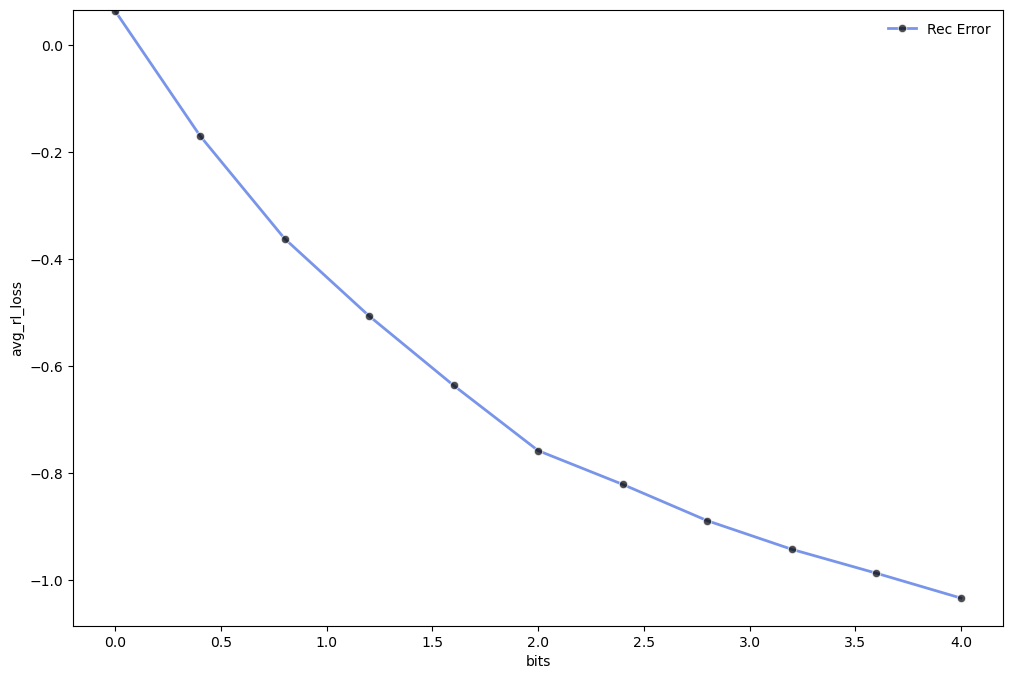

In [39]:
# Plots Rec los vs bits 
fig, ax1 = plt.subplots(figsize=(12,8))
ax1 = sns.lineplot(
            final_df,x=final_df["bits"], y=final_df["avg_rl_loss"],
            lw = 2, color = "royalblue", alpha = 0.7, label="Rec Error",
            marker = "o", markerfacecolor="black")

ax1.set_ylim([
            np.min(final_df["avg_rl_loss"])*1.05,
            np.max(final_df["avg_rl_loss"])*1.05
            ])

ax1.legend(frameon = False, ncol=2)
plt.show()